In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk

import string

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/Data/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.shape

(568454, 10)

# Data Preprocessing

In [4]:
df = df[["Score", "Text"]]

In [5]:
def map_sentiment(score):
    if score <= 2:
        return 0
    elif score == 3:
        return 1
    else:
        return 2

df['label'] = df['Score'].apply(map_sentiment)
df.drop('Score', inplace=True, axis=1)

In [6]:
df.head()

,Text,label
0,I have bought several of the Vitality canned d...,2
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,2
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,2


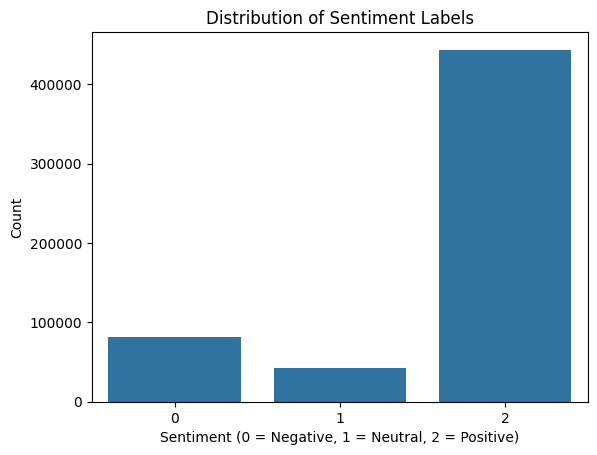

In [7]:
def plot_sent_labels_count(data, title=None):
    sns.countplot(data=data, x='label')
    plt.title(title)
    plt.xlabel('Sentiment (0 = Negative, 1 = Neutral, 2 = Positive)')
    plt.ylabel('Count')
    plt.show()

plot_sent_labels_count(data=df, title='Distribution of Sentiment Labels')

Undersampling Positive Sentiments

In [8]:
!pip install imbalanced-learn

In [9]:
X, y = df[['Text']].to_numpy(), df[['label']].to_numpy()

In [10]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='not minority')

X_resampled, y_resampled = undersample.fit_resample(X, y)

In [11]:
X_df_resampled = pd.Series(X_resampled.flatten(), name='Text')
y_df_resampled = pd.Series(y_resampled.flatten(), name='label')

resampled_df = pd.concat([X_df_resampled, y_df_resampled], axis=1)

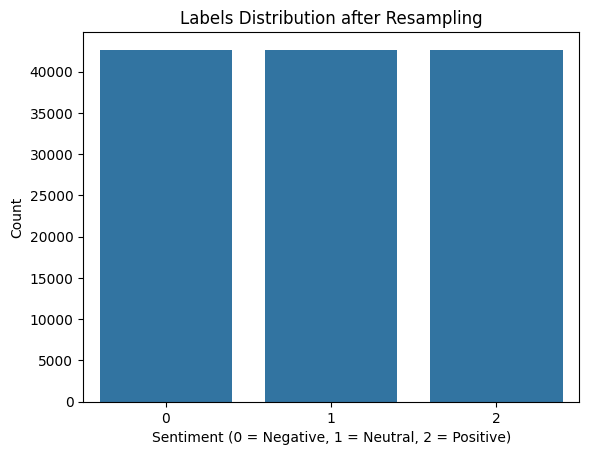

In [12]:

plot_sent_labels_count(data=resampled_df, title='Labels Distribution after Resampling')

plotting top words appear in each sentiment

In [13]:
import re
from bs4 import BeautifulSoup

# filtering dataset for negative & postive sentiments
df_filtered = resampled_df[resampled_df['label'].isin([0, 2])]

def preprocess_text(text):
    # Remove HTML tags like <br>
    text = BeautifulSoup(text, "html.parser").get_text()

    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers

    return text

df_filtered['clean_text'] = df_filtered['Text'].apply(preprocess_text)

<ipython-input-13-8a34c4121e53>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['clean_text'] = df_filtered['Text'].apply(preprocess_text)


In [14]:
# splitting data by labels
positive_texts = df_filtered[df_filtered["label"] == 2]['clean_text']
negative_texts = df_filtered[df_filtered["label"] == 0]['clean_text']

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
vectorizer.fit(df_filtered['clean_text'])

pos_matrix = vectorizer.transform(positive_texts)
neg_matrix = vectorizer.transform(negative_texts)

# get word frequencies
pos_freq = pos_matrix.sum(axis=0).A1
neg_freq = neg_matrix.sum(axis=0).A1

words = vectorizer.get_feature_names_out()

# create DataFrames
pos_df = pd.DataFrame({'word': words, 'frequency': pos_freq})
neg_df = pd.DataFrame({'word': words, 'frequency': neg_freq})

top_pos = pos_df.sort_values(by='frequency', ascending=False).head(10)
top_neg = neg_df.sort_values(by='frequency', ascending=False).head(10)

<ipython-input-16-7150470657a3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pos, x="frequency", y="word", palette='Greens_r')
<ipython-input-16-7150470657a3>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_neg, x="frequency", y="word", palette='Reds_r')


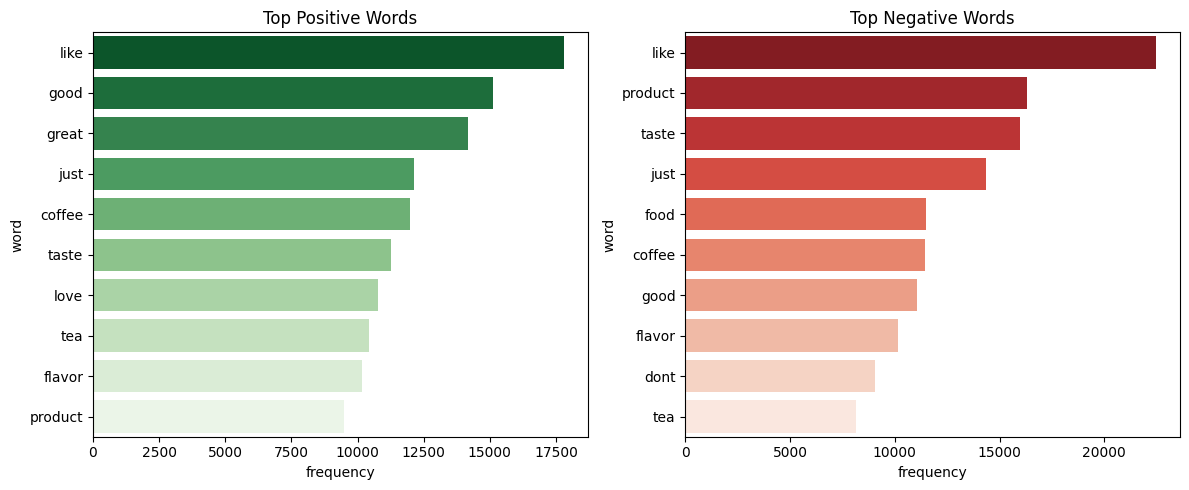

In [16]:
plt.figure(figsize=(12, 5))

# plot positive words
plt.subplot(1, 2, 1)
sns.barplot(data=top_pos, x="frequency", y="word", palette='Greens_r')
plt.title('Top Positive Words')

# plot negative words
plt.subplot(1, 2, 2)
sns.barplot(data=top_neg, x="frequency", y="word", palette='Reds_r')
plt.title('Top Negative Words')

plt.tight_layout()
plt.show()

#Model Training

##BERT Model

In [ ]:
from transformers import BertTokenizerFast
from transformers import BertModel

model_id="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

###Preparing Data for BERT Model

tokenize data

In [ ]:
def preprocess_tokenizer(examples):
    return tokenizer(examples["Text"], padding=True, truncation=True)

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [ ]:
from datasets import Dataset

# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(resampled_df)

# Tokenize with batching
tokenized_dataset = hf_dataset.map(preprocess_tokenizer, batched=True)

Map:   0%|          | 0/127920 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

Dataset({
    features: ['Text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 127920
})

In [ ]:
# Calculating tokens length
token_lengths = []

for token in tokenized_dataset["Text"]:
    token_lengths.append(len(token))

Text(0.5, 0, 'Tokens Length')

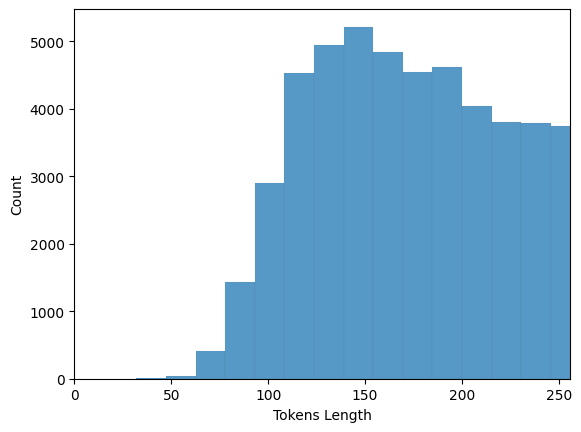

In [ ]:
# Plotting tokens lengths
sns.histplot(token_lengths)
plt.xlim([0, 256])
plt.xlabel("Tokens Length")

Split Data

In [ ]:
BATCH_SIZE = 8

In [ ]:
# selecting the first 20k samples
tokenized_dataset = tokenized_dataset.shuffle(seed=42).select(range(40000))

# train-test split the dataset
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

# create Tensorflow dataset for train data
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size = BATCH_SIZE
)

# create Tensorflow dataset for test data
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size = BATCH_SIZE
)

Restructure Data Format for BERT Model

In [ ]:
def restructure_data_format(data):
    return {
        'input_ids' : data['input_ids'],
        'token_type_ids' : data['token_type_ids'],
        'attention_mask' : data['attention_mask']
    }, data['label']

In [ ]:
tf_train_dataset = tf_train_dataset.map(restructure_data_format).prefetch(tf.data.AUTOTUNE)
tf_val_dataset = tf_val_dataset.map(restructure_data_format).prefetch(tf.data.AUTOTUNE)

In [ ]:
for i in tf_train_dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[  101,  1045,  4149, ...,     0,     0,     0],
       [  101,  3100,  1010, ...,     0,     0,     0],
       [  101,  1045,  2031, ...,     0,     0,     0],
       ...,
       [  101, 11937, 21756, ...,     0,     0,     0],
       [  101,  1045,  3641, ...,     0,     0,     0],
       [  101,  2009,  2003, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, nu

###Modeling

In [ ]:
from transformers import TFBertForSequenceClassification

model=TFBertForSequenceClassification.from_pretrained(model_id,num_labels=3)
model.summary()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training

In [ ]:
from transformers import create_optimizer

EPOCHS = 3
num_train_steps = (len(tokenized_dataset["train"]) // BATCH_SIZE) * EPOCHS
opt, _ = create_optimizer(init_lr=2e-5, num_train_steps=num_train_steps, num_warmup_steps=0)

Compiling

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=opt,
              metrics=["accuracy"])

Fitting

In [ ]:
# Creating early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

# fitting the model
history = model.fit(tf_train_dataset,
                    validation_data=tf_val_dataset,
                    epochs=EPOCHS,
                    callbacks=[early_stopping])

Epoch 1/3
4000/4000 [==============================] - 4141s 1s/step - loss: 0.5564 - accuracy: 0.7612 - val_loss: 0.4982 - val_accuracy: 0.8023
Epoch 2/3
4000/4000 [==============================] - 4076s 1s/step - loss: 0.3437 - accuracy: 0.8652 - val_loss: 0.4543 - val_accuracy: 0.8286
Epoch 3/3
4000/4000 [==============================] - 4027s 1s/step - loss: 0.1807 - accuracy: 0.9374 - val_loss: 0.5529 - val_accuracy: 0.8230


Save BERT Model

In [17]:
import json

def save_history(model_history ,path):
    with open(path, 'w') as f:
        json.dump(model_history.history, f)

def load_file(file):
    with open(file, 'r') as f:
        return json.load(f)

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# save BERT model
model.save_pretrained("/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/my_bert_model")

# save the tokenizer
# tokenizer.save_pretrained("/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/my_bert_model")

# save model's history for comparison (later)
save_history(history, "/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/bert_training_history.json")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Plot Model's Loss & Accuracy

In [ ]:
def plot_val_train_loss(model_history, model_name=None):
    plt.plot(model_history["loss"])
    plt.plot(model_history["val_loss"])

    plt.title(f"{model_name} Model Loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.legend(["train loss", "val loss"], loc="lower left")
    plt.show()

In [ ]:
def plot_val_train_acc(model_history, model_name=None):
    plt.plot(model_history["accuracy"])
    plt.plot(model_history["val_accuracy"])

    plt.title(f"{model_name} Model Accuracy")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.legend(["train accuracy", "val accuracy"], loc="lower left")
    plt.show()

In [ ]:
bert = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/my_bert_model")

Some layers from the model checkpoint at /content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/my_bert_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/my_bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertFor

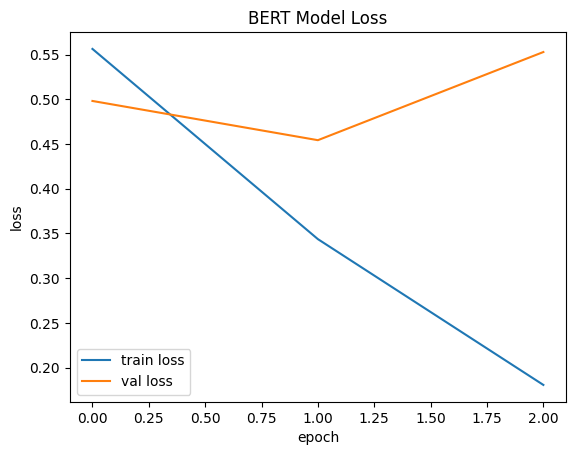

In [ ]:
# loading BERT history
bert_history = load_file('/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/bert_training_history.json')

# plotting BERT loss
plot_val_train_loss(bert_history, 'BERT')

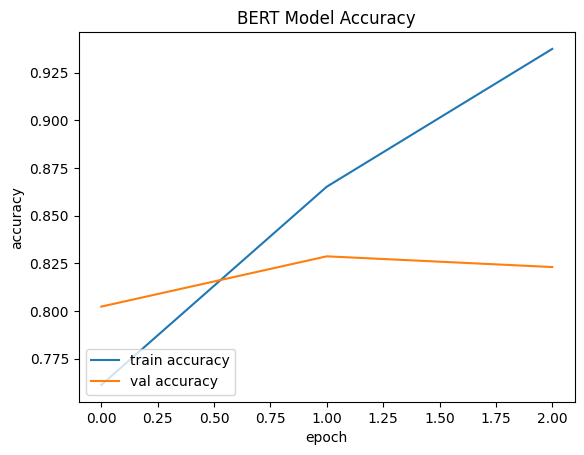

In [ ]:
# plotting BERT Accuracy
plot_val_train_acc(bert_history, 'BERT')

##Naive Bayes

In [ ]:
import nltk
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

nltk.download('punkt_tab')
nltk.download('stopwords')

def preprocess_text(text):
    # convert text to lower case
    text = text.lower()

    # remove punctuations
    translator = str.maketrans('','', string.punctuation)
    text = text.translate(translator)

    # tokenize words
    tokens = nltk.word_tokenize(text)

    # creating a set for stopwords
    stopwords_set = set(stopwords.words("english"))

    # Stemming words
    stemmer = PorterStemmer()
    stem_tokens =  [stemmer.stem(token) for token in tokens if token not in stopwords_set]

    # join tokens for CountVectorizer and return them
    return ' '.join(stem_tokens)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from tqdm import tqdm
tqdm.pandas()

preprocessed_series = resampled_df["Text"].progress_map(preprocess_text)

100%|██████████| 127920/127920 [03:13<00:00, 659.60it/s]


In [ ]:
preprocessed_series

,Text
0,tea ok bitter disappoint search jasmin oolong ...
1,order coffe year sudden chang packag can longe...
2,tri flavor stevia one isnt good other weak lem...
3,heck im disappoint receiv expect expect ginger...
4,two time occur advertis product name receiv pr...
...,...
127915,final two great tast tea pick two tea whim tar...
127916,wasnt sure instant type kcup pleasant surpris ...
127917,shampoo actual work year year purchas antidand...
127918,ive use sever differ brand coffe year new favo...


In [18]:
# saving preprocessed text
prep_txt_path = "/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/preprocessed_text.json"

In [ ]:
# converting preprocessed Series to list
preprocessed_text_list = preprocessed_series.tolist()

with open(prep_txt_path, 'w') as f:
        json.dump(preprocessed_text_list, f)

In [20]:
def load_prep_txt():
    # loading the tokenized text
    preprocessed_text = load_file(prep_txt_path)

    # converting the preprocessed text to a Pandas Series
    preprocessed_series = pd.Series(data=preprocessed_text, name='Text')

    # merging preprocessed text with labels
    return pd.concat([preprocessed_series, resampled_df["label"]], axis=1)

df = load_prep_txt()
df.head()

,Text,label
0,tea ok bitter disappoint search jasmin oolong ...,0
1,order coffe year sudden chang packag can longe...,0
2,tri flavor stevia one isnt good other weak lem...,0
3,heck im disappoint receiv expect expect ginger...,0
4,two time occur advertis product name receiv pr...,0


### Modeling

Prepare Data for Naive Bayes

In [22]:
from sklearn.model_selection import train_test_split

def count_vec_and_split(df):
    cv = CountVectorizer()

    train, test = train_test_split(df, train_size=0.8, random_state=42)

    X_train, y_train = cv.fit_transform(train["Text"]), train["label"]
    X_test, y_test = cv.transform(test["Text"]), test["label"]

    return X_train, y_train, X_test, y_test

In [23]:
X_train, y_train, X_test, y_test = count_vec_and_split(df)

In [24]:
X_train[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y_train[:5]

,label
7380,0
119194,2
17056,0
42606,0
63641,1


Train Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
predictions = nb.predict(X_test)

In [ ]:
y_score = nb.predict_proba(X_test)
y_score

array([[7.30055967e-05, 9.80147762e-01, 1.97792328e-02],
       [4.94428602e-01, 4.00217768e-01, 1.05353630e-01],
       [1.00000000e+00, 4.03290062e-13, 1.25375131e-13],
       ...,
       [7.35615692e-03, 9.79823673e-02, 8.94661476e-01],
       [8.41433014e-02, 2.02113693e-01, 7.13743005e-01],
       [3.08444023e-02, 9.47229780e-01, 2.19258176e-02]])

Model Evaluation

In [ ]:
nb_report = accuracy_score(y_test,predictions)
print('Accuracy:',nb_report)

Accuracy: 0.6860537836147592


In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.70      0.67      0.68      8649
           1       0.60      0.64      0.62      8523
           2       0.77      0.75      0.76      8412

    accuracy                           0.69     25584
   macro avg       0.69      0.69      0.69     25584
weighted avg       0.69      0.69      0.69     25584



In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

Label Binarization

In [ ]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

ROC Curve

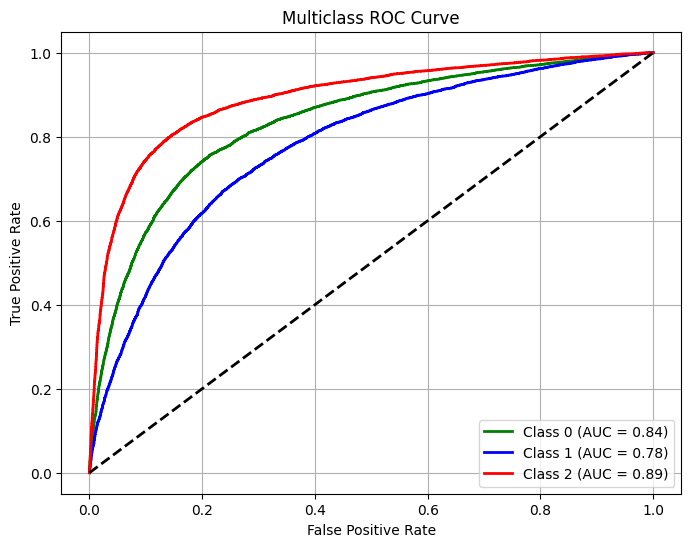

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['green', 'blue', 'red']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Logistic Regression

In [25]:
# get preprocessed data
df = load_prep_txt()
df.head()

,Text,label
0,tea ok bitter disappoint search jasmin oolong ...,0
1,order coffe year sudden chang packag can longe...,0
2,tri flavor stevia one isnt good other weak lem...,0
3,heck im disappoint receiv expect expect ginger...,0
4,two time occur advertis product name receiv pr...,0


In [26]:
# prepare data for Logstic Regression
X_train, y_train, X_test, y_test = count_vec_and_split(df)
X_train[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
y_train[:5]

,label
7380,0
119194,2
17056,0
42606,0
63641,1


In [30]:
from sklearn.linear_model import LogisticRegression

# create logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# fit the model
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [32]:
# predicting the test set
y_pred = model.predict(X_test)

# display classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73      8649
           1       0.66      0.64      0.65      8523
           2       0.77      0.80      0.79      8412

    accuracy                           0.72     25584
   macro avg       0.72      0.73      0.72     25584
weighted avg       0.72      0.72      0.72     25584

